<a href="https://colab.research.google.com/github/santiagonajera/Ventas-Diarias/blob/main/parte1-forecasr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo para las gráficas
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def load_and_prepare_data(url):
    """Cargar y preparar los datos"""
    # Cargar datos desde GitHub (usando el raw URL)
    raw_url = url.replace('github.com', 'raw.githubusercontent.com').replace('/blob', '')
    df = pd.read_csv(raw_url)

    # Convertir la columna de fecha a datetime
    df['Fecha'] = pd.to_datetime(df['Fecha'])

    # Ordenar por fecha
    df = df.sort_values('Fecha').reset_index(drop=True)

    return df

def aggregate_to_monthly(df):
    """Convertir datos diarios a mensuales"""
    # Agrupar por mes y sumar las ventas
    df_monthly = df.groupby(df['Fecha'].dt.to_period('M')).agg({
        'Pizza': 'sum',
        'Hamburguesa': 'sum',
        'Ensalada': 'sum',
        'Sushi': 'sum'
    }).reset_index()

    # Convertir el período a fecha (primer día del mes)
    df_monthly['Fecha'] = df_monthly['Fecha'].dt.to_timestamp()

    return df_monthly

def analyze_seasonality_and_trend(df_monthly, product):
    """Analizar estacionalidad y tendencia para un producto"""
    # Crear serie temporal
    ts = df_monthly.set_index('Fecha')[product]

    # Descomposición de la serie temporal
    decomposition = seasonal_decompose(ts, model='additive', period=12)

    return decomposition

def forecast_next_3_months(df_monthly, product):
    """Generar forecast para los próximos 3 meses"""
    # Crear serie temporal
    ts = df_monthly.set_index('Fecha')[product]

    # Modelo de suavizamiento exponencial con tendencia y estacionalidad
    model = ExponentialSmoothing(
        ts,
        trend='add',
        seasonal='add',
        seasonal_periods=12,
        initialization_method='estimated'
    )

    # Ajustar el modelo
    fitted_model = model.fit()

    # Forecast para los próximos 3 meses
    forecast = fitted_model.forecast(steps=3)

    # Intervalos de confianza
    forecast_ci = fitted_model.conf_int(alpha=0.05)
    forecast_ci_next = forecast_ci.iloc[-3:]

    return forecast, forecast_ci_next, fitted_model

def create_forecast_dates(last_date, periods=3):
    """Crear fechas para el forecast"""
    forecast_dates = []
    current_date = last_date

    for i in range(periods):
        # Agregar un mes
        if current_date.month == 12:
            next_date = current_date.replace(year=current_date.year + 1, month=1, day=1)
        else:
            next_date = current_date.replace(month=current_date.month + 1, day=1)
        forecast_dates.append(next_date)
        current_date = next_date

    return forecast_dates

def plot_forecast_results(df_monthly, product, forecast, forecast_dates, decomposition):
    """Crear gráficas de los resultados"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Análisis y Forecasting - {product}', fontsize=16, fontweight='bold')

    # 1. Serie original con forecast
    axes[0, 0].plot(df_monthly['Fecha'], df_monthly[product], marker='o', linewidth=2, label='Datos históricos')
    axes[0, 0].plot(forecast_dates, forecast, marker='s', linewidth=2, color='red', label='Forecast')
    axes[0, 0].set_title('Ventas Históricas y Forecast')
    axes[0, 0].set_xlabel('Fecha')
    axes[0, 0].set_ylabel('Ventas')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Tendencia
    axes[0, 1].plot(decomposition.trend.index, decomposition.trend.values, linewidth=2, color='orange')
    axes[0, 1].set_title('Tendencia')
    axes[0, 1].set_xlabel('Fecha')
    axes[0, 1].set_ylabel('Tendencia')
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Estacionalidad
    axes[1, 0].plot(decomposition.seasonal.index, decomposition.seasonal.values, linewidth=2, color='green')
    axes[1, 0].set_title('Componente Estacional')
    axes[1, 0].set_xlabel('Fecha')
    axes[1, 0].set_ylabel('Estacionalidad')
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Residuos
    axes[1, 1].plot(decomposition.resid.index, decomposition.resid.values, marker='o', linewidth=1, color='purple')
    axes[1, 1].set_title('Residuos')
    axes[1, 1].set_xlabel('Fecha')
    axes[1, 1].set_ylabel('Residuos')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

def main():
    # URL del archivo
    url = "https://github.com/santiagonajera/Ventas-Diarias/blob/main/Ventas_diarias_restaurante.csv"

    try:
        # Cargar y preparar datos
        print("Cargando datos...")
        df = load_and_prepare_data(url)
        print(f"Datos cargados: {len(df)} registros")

        # Convertir a datos mensuales
        print("Agregando datos a nivel mensual...")
        df_monthly = aggregate_to_monthly(df)
        print(f"Datos mensuales: {len(df_monthly)} meses")

        # Productos a analizar
        products = ['Pizza', 'Hamburguesa', 'Ensalada', 'Sushi']

        # Diccionario para almacenar resultados
        forecast_results = {}

        # Procesar cada producto
        for product in products:
            print(f"\nAnalizando {product}...")

            # Análisis de estacionalidad y tendencia
            decomposition = analyze_seasonality_and_trend(df_monthly, product)

            # Forecast para los próximos 3 meses
            forecast, forecast_ci, model = forecast_next_3_months(df_monthly, product)

            # Crear fechas para el forecast
            last_date = df_monthly['Fecha'].iloc[-1]
            forecast_dates = create_forecast_dates(last_date)

            # Almacenar resultados
            forecast_results[product] = {
                'forecast': forecast,
                'forecast_dates': forecast_dates,
                'confidence_intervals': forecast_ci,
                'decomposition': decomposition,
                'model': model
            }

            # Mostrar resultados numéricos
            print(f"Forecast para {product} (próximos 3 meses):")
            for i, (date, value) in enumerate(zip(forecast_dates, forecast)):
                print(f"  {date.strftime('%Y-%m')}: {value:.1f}")

            # Crear gráficas
            plot_forecast_results(df_monthly, product, forecast, forecast_dates, decomposition)

        # Crear resumen de forecasts
        print("\n" + "="*60)
        print("RESUMEN DE FORECASTS - PRÓXIMOS 3 MESES")
        print("="*60)

        # Crear DataFrame con todos los forecasts
        summary_data = []
        for product in products:
            forecast = forecast_results[product]['forecast']
            forecast_dates = forecast_results[product]['forecast_dates']

            for i, (date, value) in enumerate(zip(forecast_dates, forecast)):
                summary_data.append({
                    'Producto': product,
                    'Mes': date.strftime('%Y-%m'),
                    'Forecast': round(value, 1)
                })

        summary_df = pd.DataFrame(summary_data)
        summary_pivot = summary_df.pivot(index='Mes', columns='Producto', values='Forecast')
        print(summary_pivot)

        # Guardar resultados en CSV
        summary_df.to_csv('forecast_resultados.csv', index=False)
        print(f"\nResultados guardados en 'forecast_resultados.csv'")

        # Mostrar estadísticas descriptivas
        print("\n" + "="*60)
        print("ESTADÍSTICAS DESCRIPTIVAS - DATOS MENSUALES")
        print("="*60)
        monthly_stats = df_monthly[products].describe()
        print(monthly_stats.round(2))

    except Exception as e:
        print(f"Error: {str(e)}")
        print("Asegúrate de tener conexión a internet y que el archivo esté disponible en la URL proporcionada.")

if __name__ == "__main__":
    main()

Cargando datos...
Datos cargados: 731 registros
Agregando datos a nivel mensual...
Datos mensuales: 24 meses

Analizando Pizza...
Error: 'HoltWintersResults' object has no attribute 'conf_int'
Asegúrate de tener conexión a internet y que el archivo esté disponible en la URL proporcionada.


Cargando datos desde GitHub...
Datos cargados: 731 registros
Agregando datos a nivel mensual...
Datos mensuales: 24 meses

Analizando Pizza...
Forecast para Pizza (próximos 3 meses):
  2025-01: 2217.7
  2025-02: 1912.3
  2025-03: 1876.7


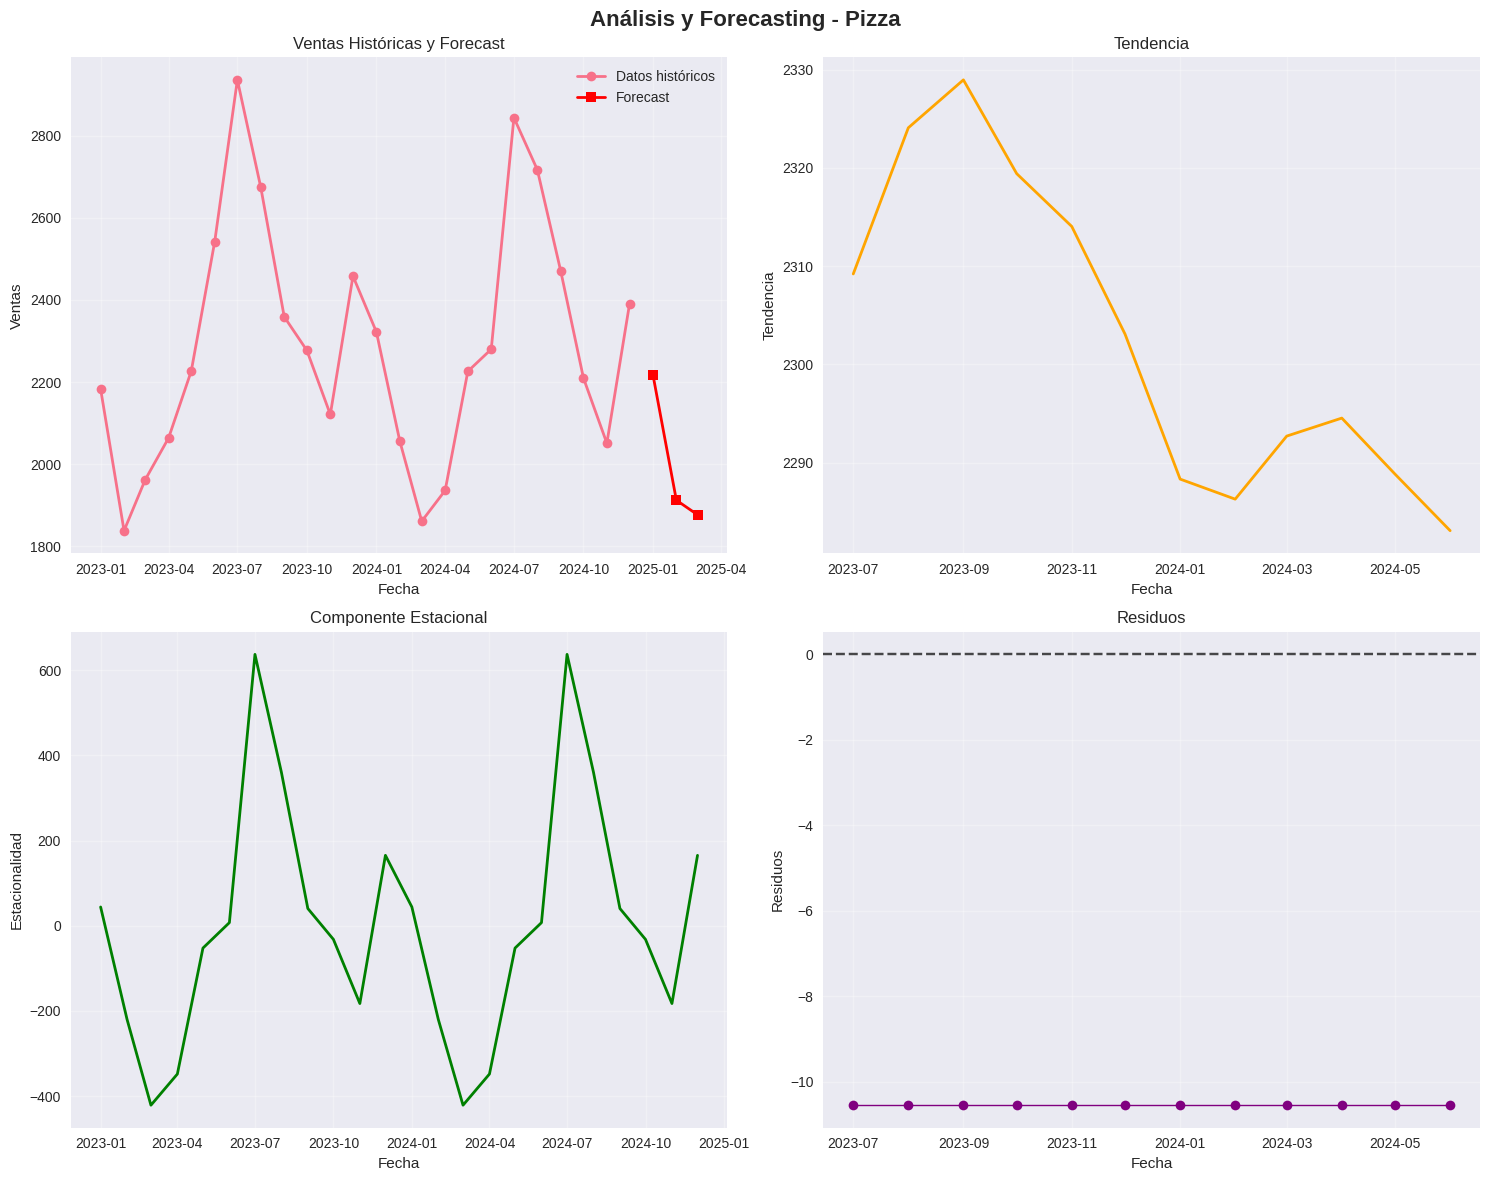


Analizando Hamburguesa...
Forecast para Hamburguesa (próximos 3 meses):
  2025-01: 1775.5
  2025-02: 1569.0
  2025-03: 1640.5


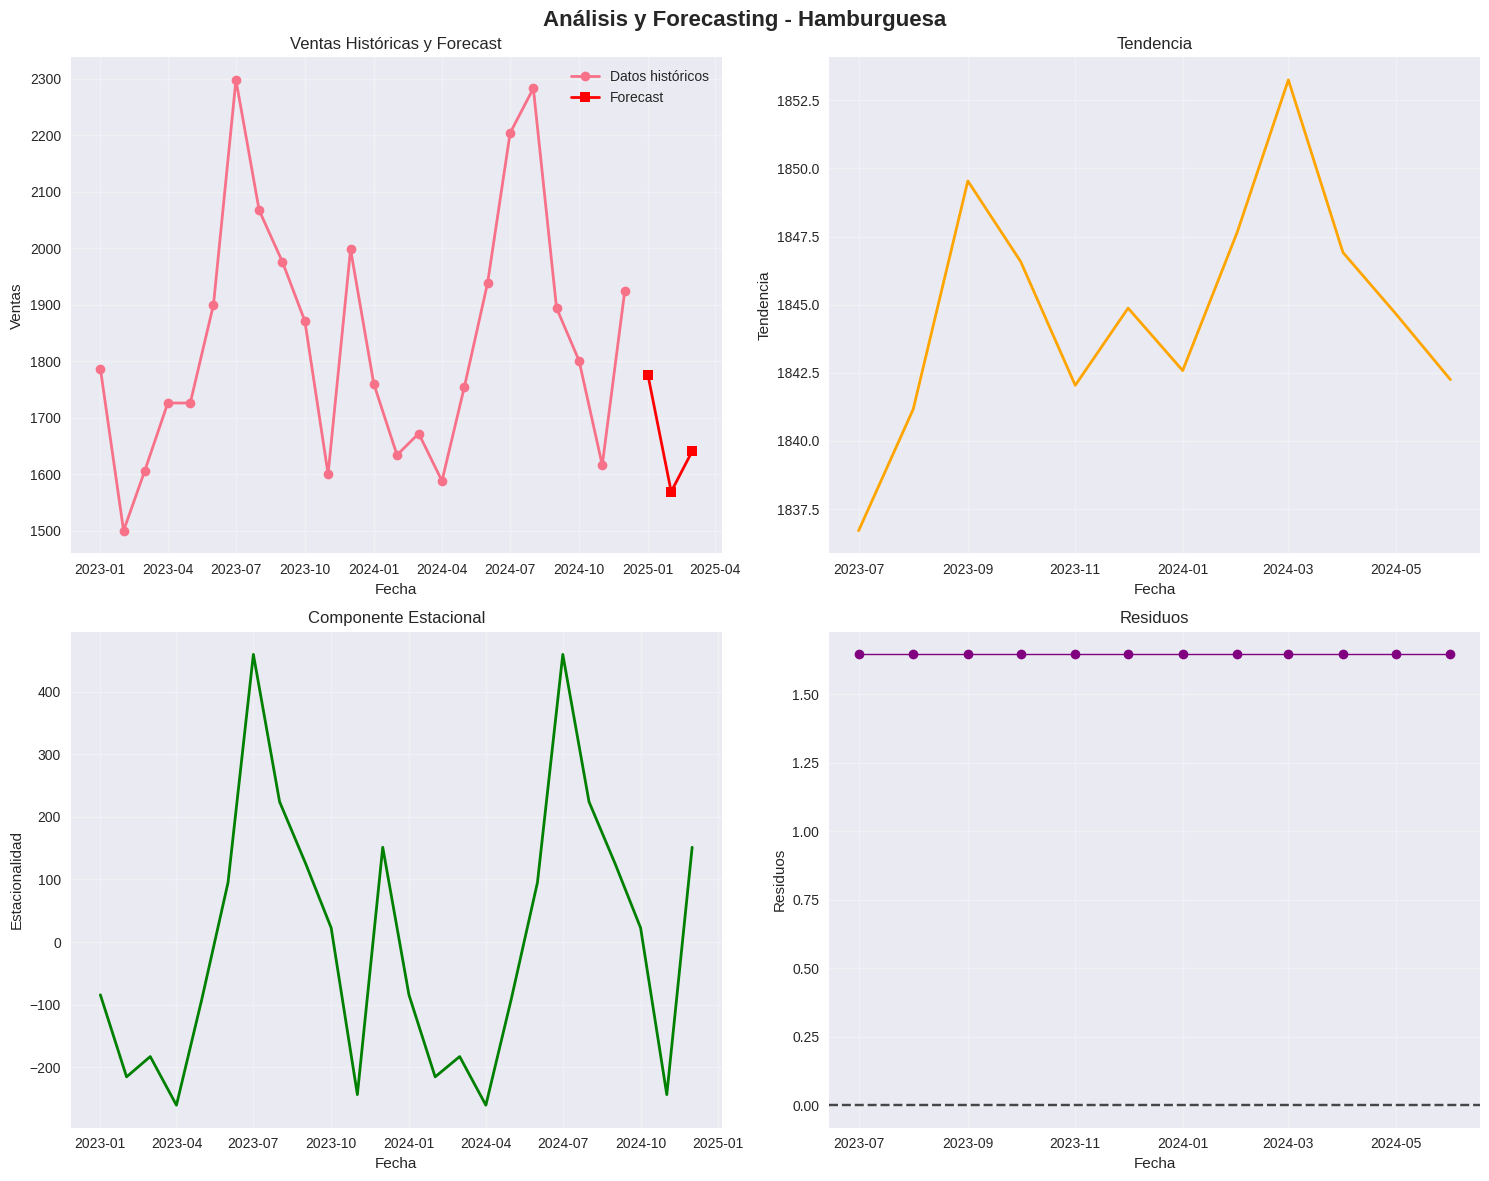


Analizando Ensalada...
Forecast para Ensalada (próximos 3 meses):
  2025-01: 1074.9
  2025-02: 893.9
  2025-03: 863.4


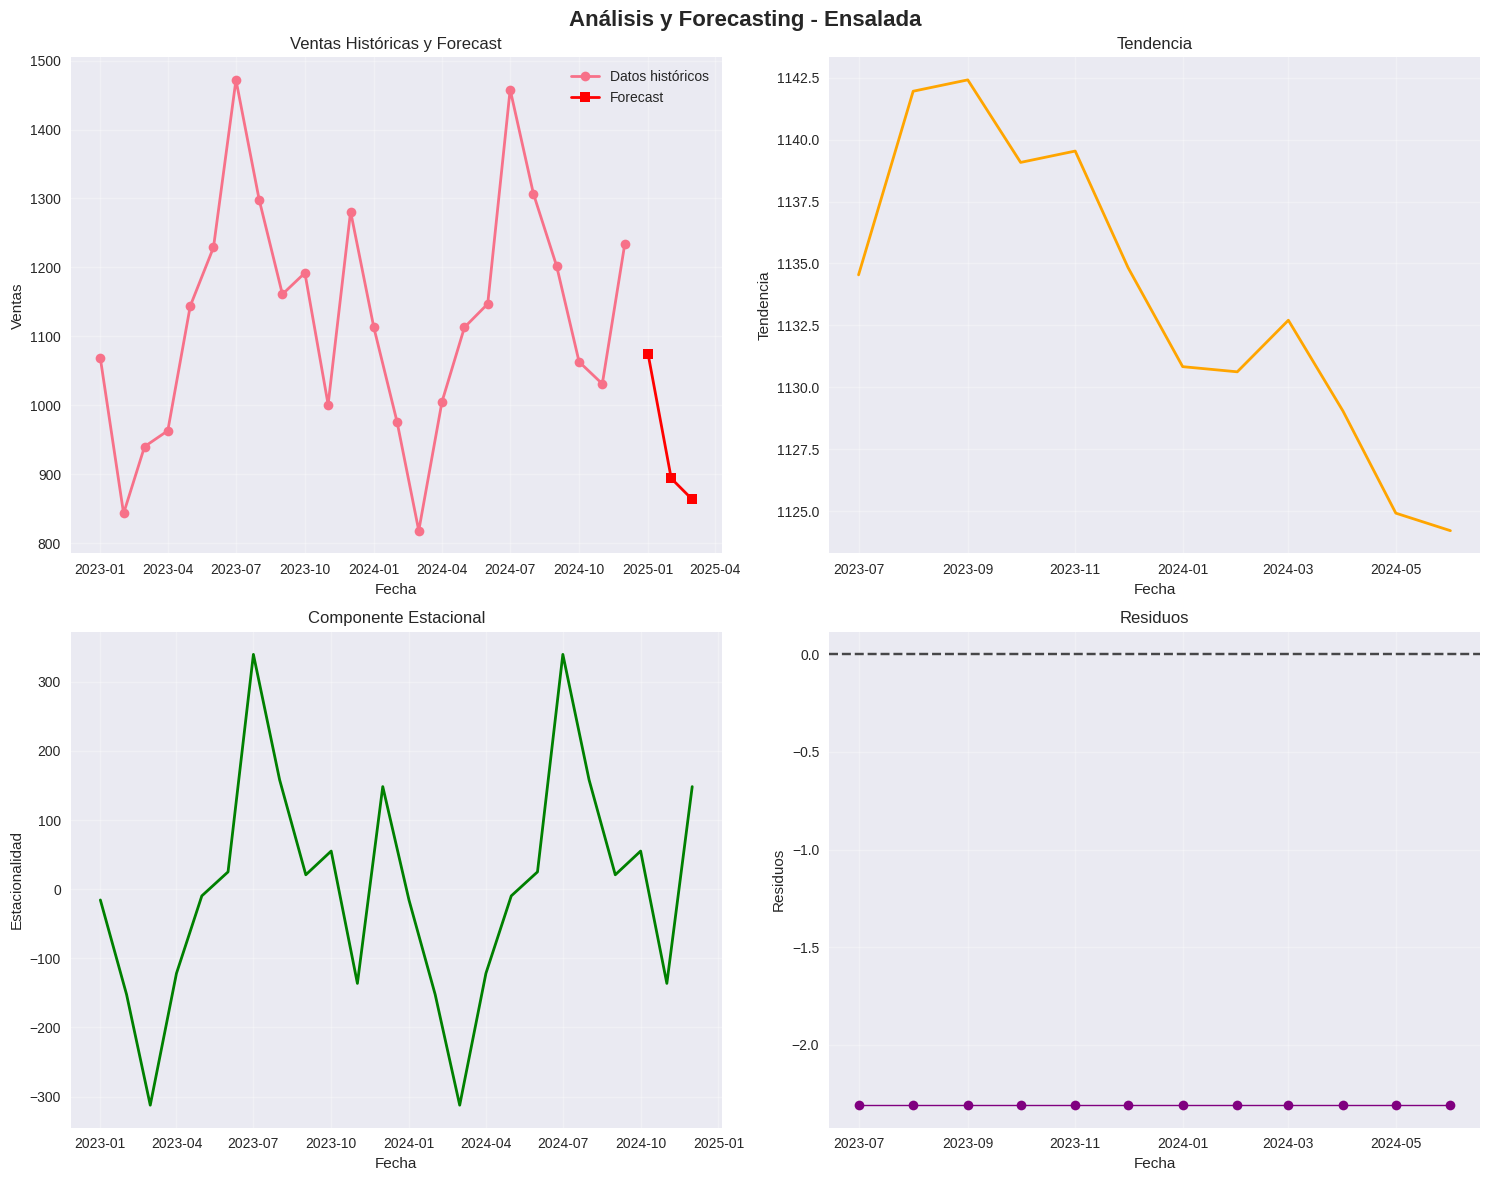


Analizando Sushi...
Forecast para Sushi (próximos 3 meses):
  2025-01: 1450.1
  2025-02: 1258.1
  2025-03: 1180.1


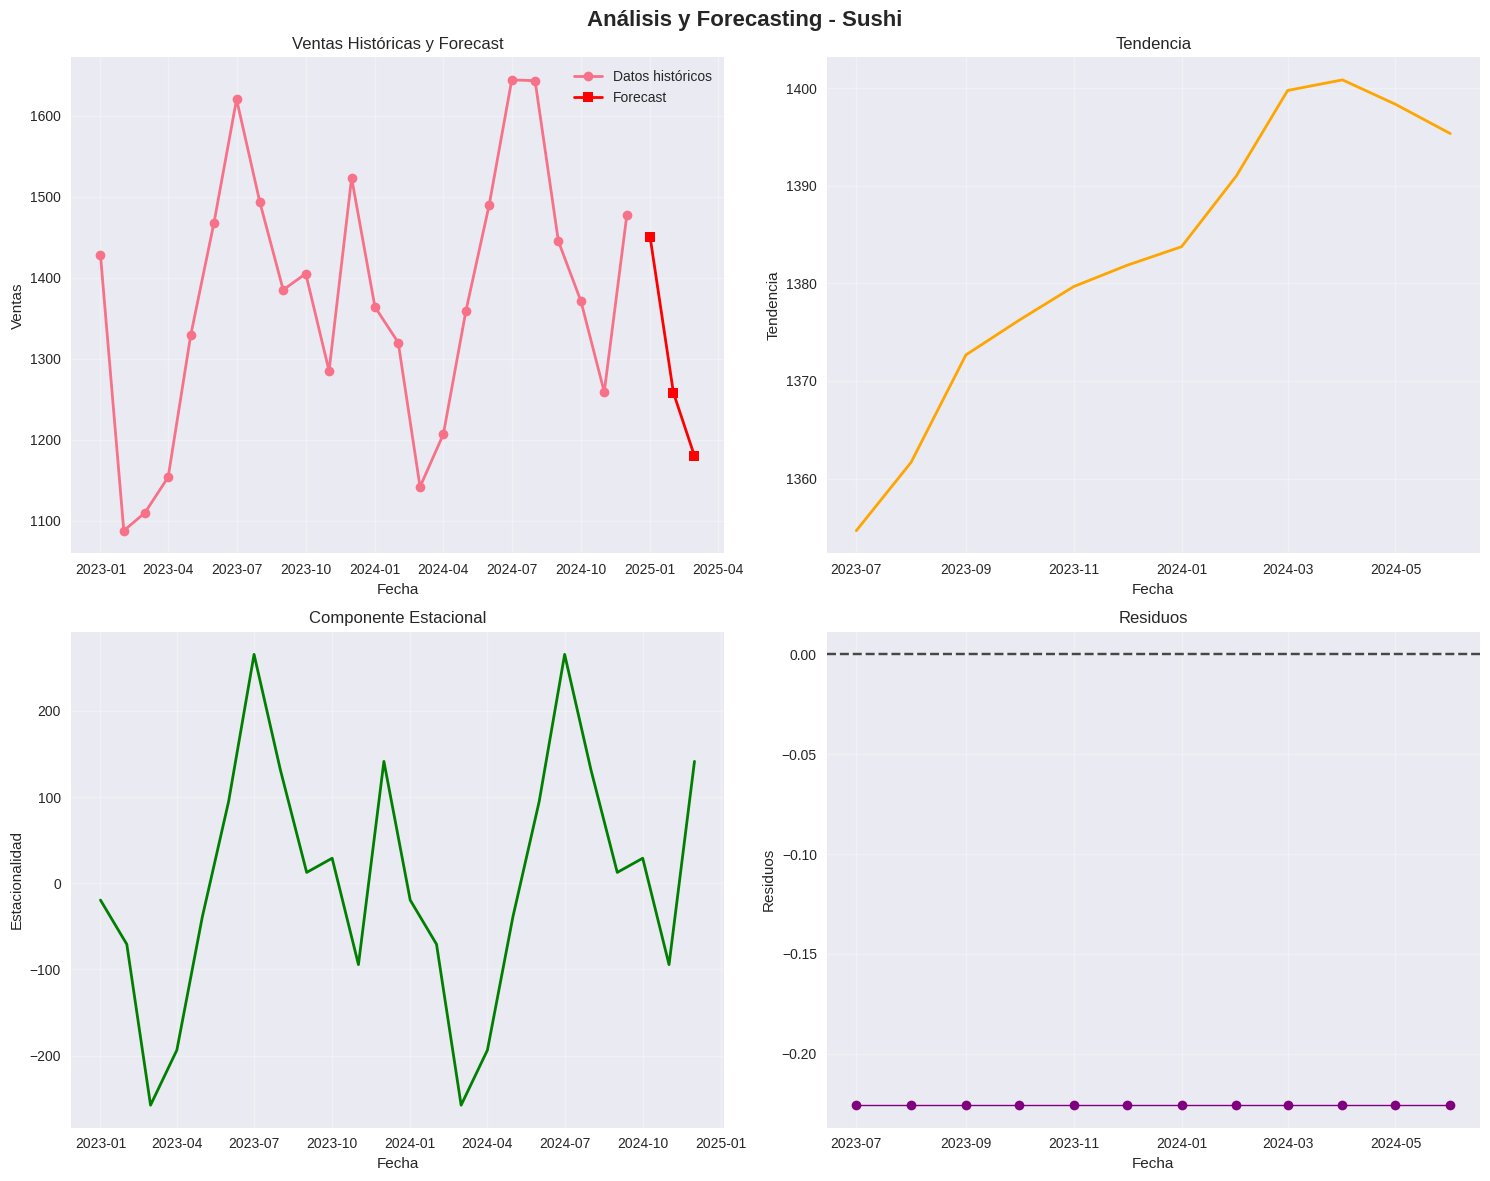


RESUMEN DE FORECASTS - PRÓXIMOS 3 MESES
Producto  Ensalada  Hamburguesa   Pizza   Sushi
Mes                                            
2025-01     1074.9       1775.5  2217.7  1450.1
2025-02      893.9       1569.0  1912.3  1258.1
2025-03      863.4       1640.5  1876.7  1180.1

Resultados guardados en 'forecast_resultados.csv'

ESTADÍSTICAS DESCRIPTIVAS - DATOS MENSUALES
         Pizza  Hamburguesa  Ensalada    Sushi
count    24.00        24.00     24.00    24.00
mean   2291.83      1838.50   1127.46  1375.38
std     297.29       220.13    168.91   160.44
min    1838.00      1500.00    818.00  1088.00
25%    2062.00      1662.50   1004.00  1278.50
50%    2252.00      1794.00   1128.50  1378.00
75%    2461.00      1948.25   1230.25  1480.25
max    2936.00      2298.00   1472.00  1644.00


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo para las gráficas
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def load_and_prepare_data(url):
    """Cargar y preparar los datos desde GitHub"""
    # Convertir URL de GitHub a URL raw
    raw_url = url.replace('github.com', 'raw.githubusercontent.com').replace('/blob', '')

    # Cargar datos
    df = pd.read_csv(raw_url)

    # Convertir la columna de fecha a datetime
    df['Fecha'] = pd.to_datetime(df['Fecha'])

    # Ordenar por fecha
    df = df.sort_values('Fecha').reset_index(drop=True)

    return df

def aggregate_to_monthly(df):
    """Convertir datos diarios a mensuales"""
    # Agrupar por mes y sumar las ventas
    df_monthly = df.groupby(df['Fecha'].dt.to_period('M')).agg({
        'Pizza': 'sum',
        'Hamburguesa': 'sum',
        'Ensalada': 'sum',
        'Sushi': 'sum'
    }).reset_index()

    # Convertir el período a fecha (primer día del mes)
    df_monthly['Fecha'] = df_monthly['Fecha'].dt.to_timestamp()

    return df_monthly

def analyze_seasonality_and_trend(df_monthly, product):
    """Analizar estacionalidad y tendencia para un producto"""
    # Crear serie temporal
    ts = df_monthly.set_index('Fecha')[product]

    # Descomposición de la serie temporal
    decomposition = seasonal_decompose(ts, model='additive', period=12)

    return decomposition

def forecast_next_3_months(df_monthly, product):
    """Generar forecast para los próximos 3 meses"""
    # Crear serie temporal
    ts = df_monthly.set_index('Fecha')[product]

    # Modelo de suavizamiento exponencial con tendencia y estacionalidad
    model = ExponentialSmoothing(
        ts,
        trend='add',
        seasonal='add',
        seasonal_periods=12,
        initialization_method='estimated'
    )

    # Ajustar el modelo
    fitted_model = model.fit()

    # Forecast para los próximos 3 meses
    forecast = fitted_model.forecast(steps=3)

    return forecast, fitted_model

def create_forecast_dates(last_date, periods=3):
    """Crear fechas para el forecast"""
    forecast_dates = []
    current_date = last_date

    for i in range(periods):
        # Agregar un mes
        if current_date.month == 12:
            next_date = current_date.replace(year=current_date.year + 1, month=1, day=1)
        else:
            next_date = current_date.replace(month=current_date.month + 1, day=1)
        forecast_dates.append(next_date)
        current_date = next_date

    return forecast_dates

def plot_forecast_results(df_monthly, product, forecast, forecast_dates, decomposition):
    """Crear gráficas de los resultados"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Análisis y Forecasting - {product}', fontsize=16, fontweight='bold')

    # 1. Serie original con forecast
    axes[0, 0].plot(df_monthly['Fecha'], df_monthly[product], marker='o', linewidth=2, label='Datos históricos')
    axes[0, 0].plot(forecast_dates, forecast, marker='s', linewidth=2, color='red', label='Forecast')
    axes[0, 0].set_title('Ventas Históricas y Forecast')
    axes[0, 0].set_xlabel('Fecha')
    axes[0, 0].set_ylabel('Ventas')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Tendencia
    axes[0, 1].plot(decomposition.trend.index, decomposition.trend.values, linewidth=2, color='orange')
    axes[0, 1].set_title('Tendencia')
    axes[0, 1].set_xlabel('Fecha')
    axes[0, 1].set_ylabel('Tendencia')
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Estacionalidad
    axes[1, 0].plot(decomposition.seasonal.index, decomposition.seasonal.values, linewidth=2, color='green')
    axes[1, 0].set_title('Componente Estacional')
    axes[1, 0].set_xlabel('Fecha')
    axes[1, 0].set_ylabel('Estacionalidad')
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Residuos
    axes[1, 1].plot(decomposition.resid.index, decomposition.resid.values, marker='o', linewidth=1, color='purple')
    axes[1, 1].set_title('Residuos')
    axes[1, 1].set_xlabel('Fecha')
    axes[1, 1].set_ylabel('Residuos')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

def main():
    # URL del archivo en GitHub
    url = "https://github.com/santiagonajera/Ventas-Diarias/blob/main/Ventas_diarias_restaurante.csv"

    try:
        # Cargar y preparar datos
        print("Cargando datos desde GitHub...")
        df = load_and_prepare_data(url)
        print(f"Datos cargados: {len(df)} registros")

        # Convertir a datos mensuales
        print("Agregando datos a nivel mensual...")
        df_monthly = aggregate_to_monthly(df)
        print(f"Datos mensuales: {len(df_monthly)} meses")

        # Productos a analizar
        products = ['Pizza', 'Hamburguesa', 'Ensalada', 'Sushi']

        # Diccionario para almacenar resultados
        forecast_results = {}

        # Procesar cada producto
        for product in products:
            print(f"\nAnalizando {product}...")

            # Análisis de estacionalidad y tendencia
            decomposition = analyze_seasonality_and_trend(df_monthly, product)

            # Forecast para los próximos 3 meses
            forecast, model = forecast_next_3_months(df_monthly, product)

            # Crear fechas para el forecast
            last_date = df_monthly['Fecha'].iloc[-1]
            forecast_dates = create_forecast_dates(last_date)

            # Almacenar resultados
            forecast_results[product] = {
                'forecast': forecast,
                'forecast_dates': forecast_dates,
                'decomposition': decomposition,
                'model': model
            }

            # Mostrar resultados numéricos
            print(f"Forecast para {product} (próximos 3 meses):")
            for i, (date, value) in enumerate(zip(forecast_dates, forecast)):
                print(f"  {date.strftime('%Y-%m')}: {value:.1f}")

            # Crear gráficas
            plot_forecast_results(df_monthly, product, forecast, forecast_dates, decomposition)

        # Crear resumen de forecasts
        print("\n" + "="*60)
        print("RESUMEN DE FORECASTS - PRÓXIMOS 3 MESES")
        print("="*60)

        # Crear DataFrame con todos los forecasts
        summary_data = []
        for product in products:
            forecast = forecast_results[product]['forecast']
            forecast_dates = forecast_results[product]['forecast_dates']

            for i, (date, value) in enumerate(zip(forecast_dates, forecast)):
                summary_data.append({
                    'Producto': product,
                    'Mes': date.strftime('%Y-%m'),
                    'Forecast': round(value, 1)
                })

        summary_df = pd.DataFrame(summary_data)
        summary_pivot = summary_df.pivot(index='Mes', columns='Producto', values='Forecast')
        print(summary_pivot)

        # Guardar resultados en CSV
        summary_df.to_csv('forecast_resultados.csv', index=False)
        print(f"\nResultados guardados en 'forecast_resultados.csv'")

        # Mostrar estadísticas descriptivas
        print("\n" + "="*60)
        print("ESTADÍSTICAS DESCRIPTIVAS - DATOS MENSUALES")
        print("="*60)
        monthly_stats = df_monthly[products].describe()
        print(monthly_stats.round(2))

    except Exception as e:
        print(f"Error: {str(e)}")
        print("Asegúrate de tener conexión a internet y que el archivo esté disponible en la URL proporcionada.")

if __name__ == "__main__":
    main()